# Importação e tratamento dos dados

In [ ]:
# ARIMA MODEL
# file "<stdin>", line 1: type "> realod window" and fixes the problem

# Importar Bibliotecas
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt

# Treinamento do modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os
from scipy import stats
import statsmodels

# Adfuller test
from statsmodels.tsa.stattools import adfuller

# Correlograma
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelo ARIMA
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# Arima automático
from pmdarima.arima import auto_arima

# Diagnóstico automático do modelo
from statsmodels.tsa.arima.model import ARIMAResults

import plotly.express as px

# Transformação Box Cox
from scipy.stats import boxcox

# MAPE e MSE
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Reverter valores da transformação box cox
from scipy.special import inv_boxcox

<ipython-input-45-8f12b7b32b63>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
# Leitura e tratamento dos dados
owid_co2 = pd.read_csv(r'owid-co2-data.csv')

# Criando index em formato de data
owid_co2.index = pd.to_datetime(owid_co2['year'], format='%Y')

# Separando somente os dados do Brasil
owid_brasil = owid_co2[owid_co2['country'] == 'Brazil']

# Selecionando somente a coluna de emissão de CO2
owid_brasil = owid_brasil[['co2']]

# Retirar valores nulos

owid_brasil = owid_brasil.dropna()

owid_brasil

,co2
year,
1901-01-01,2.103
1902-01-01,2.506
1903-01-01,2.440
1904-01-01,2.620
1905-01-01,2.799
...,...
2018-01-01,477.999
2019-01-01,473.464
2020-01-01,444.504


# Análise Exploratória dos Dados

In [ ]:
# Métricas acerca dos dados
## Estatísticas descritivas
owid_brasil.describe()

,co2
count,122.000000
mean,140.793303
std,168.378012
min,2.103000
25%,5.533250
50%,51.374500
75%,232.549250
max,557.901000


In [ ]:
## Verificar a presença de valores nulos
print('valores nulos:', owid_brasil.isnull().sum())

valores nulos: co2    0
dtype: int64


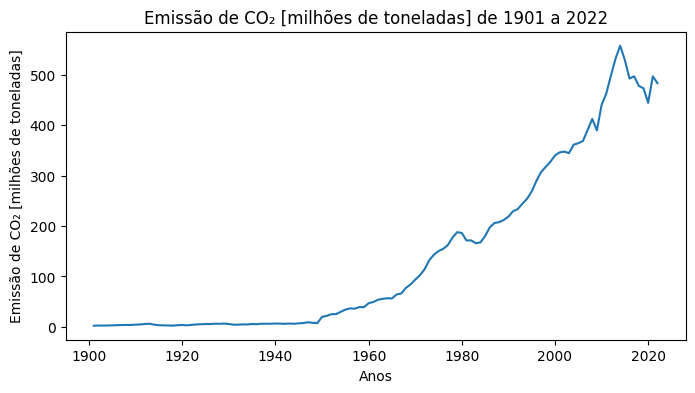

<Figure size 640x480 with 0 Axes>

In [ ]:
# Gráfico da emissão de CO2 ao longo dos anos de análise
fig1 = plt.figure(figsize=(8, 4))
plt.plot(owid_brasil['co2'])
plt.xlabel('Anos')
plt.ylabel('Emissão de CO₂ [milhões de toneladas]')
plt.title('Emissão de CO₂ [milhões de toneladas] de 1901 a 2022')

# não aparenta possuir sazonalidade já que não existem padrões que se repetem ao longo dos anos

plt.show()

plt.savefig("emissaoco2br.png")

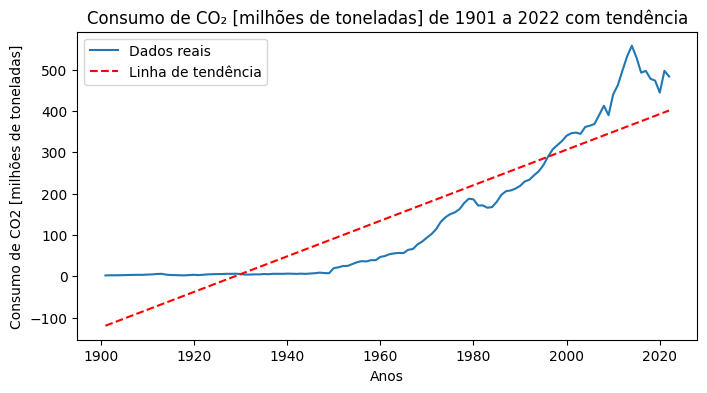

In [ ]:
# Convertendo o índice para valores numéricos
anos_numericos = owid_brasil.index.year.astype(int)

# Gráfico com tendência
fig1_2 = plt.figure(figsize=(8, 4))
plt.plot(anos_numericos, owid_brasil['co2'], label='Dados reais')
plt.xlabel('Anos')
plt.ylabel('Consumo de CO2 [milhões de toneladas]')
plt.title('Consumo de CO₂ [milhões de toneladas] de 1901 a 2022 com tendência')

# Adicionando a linha de tendência
z = np.polyfit(anos_numericos, owid_brasil['co2'], 1)
p = np.poly1d(z)
plt.plot(anos_numericos, p(anos_numericos), "r--", label='Linha de tendência')

plt.legend()  # Adiciona a legenda com base nos labels fornecidos
plt.show()
fig1_2.savefig("consumotrendbr.png")


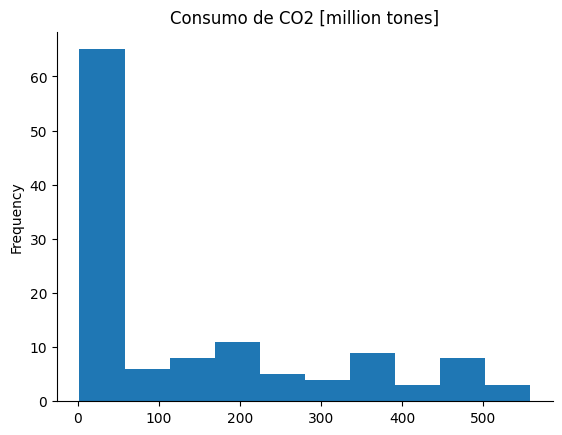

In [ ]:
# Histograma

owid_brasil['co2'].plot(kind='hist', title='Consumo de CO2 [million tones]')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.savefig("consumoco2br_hist.png")

In [ ]:
# Teste de sazonalidade
## CHECANDO PARA SAZONALIDADE ANUAL
res = []

for i in owid_brasil.index.unique():
    res.append(owid_brasil.loc[i, 'co2'])

result = stats.kruskal(*res)

if result[1] > 0.05:
  print("Não há sazonalidade")
else:
  print("Há sazonalidade")
print(result)

Não há sazonalidade
KruskalResult(statistic=121.00000000000003, pvalue=0.482901834082353)


Como o teste de **Kruskal-Wallis** indicou um p-value de 0.482, maior que o nível de significância de 5% (0,05). Dessa forma, não existe sazonalidade entre os anos de análise (1901-2022).

**Rule of thumb**

O modelo pode ser aditivo ou multiplicativo. Se a variação da tendência e variância são relativamente constantes ao longo do tempo, é aditivo. No caso contrário, tendência e variância aumentam ou diminuem ao longo do tempo, é um modelo multiplicativo.

In [ ]:
# Verificação de estacionariedade
## Teste Dickey-Fuller aumentado

# Parâmetros escolhidos
autolag_escolhido = 'AIC'

# Função para o teste de dickey-fuller aumentado
def adfuller_test(df, autolag_escolhido):
  # Null hypothesis: Non Stationarity exists in the series (raiz única)
  # Alternative Hypothesis: Stationarity exists in the series

  adfuller_test = adfuller(df, autolag = autolag_escolhido)

  if adfuller_test[1]<=0.05:
    print('Série temporal estacionária com p-value igual a:', adfuller_test[1])
  else:
    print('Série temporal não-estacionária com p-value igual a:', adfuller_test[1])
  return adfuller_test

# Aplicação da função
adfuller_test(owid_brasil, autolag_escolhido)


Série temporal não-estacionária com p-value igual a: 0.9989849942094307


(2.3503495150546008,
 0.9989849942094307,
 12,
 109,
 {'1%': -3.49181775886872,
  '5%': -2.8884437992971588,
  '10%': -2.5811201893779985},
 810.2836553337766)

# P-value do teste de Dickey-fuller aumentado

p-value é a probabilidade da hipótese nula não ser rejeitada. Se p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. Se p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Como o p-value está acima de 0,05 (ou 5%), a hipótese nula não pode ser rejeitada: **a série é não-estacionária**.

In [ ]:
# Realizando a diferenciação para torná-la estacionária

owid_brasil_diff1 = owid_brasil.diff().dropna()

# Aplicação do adfuller novamente para verificar estacionariedade:
adfuller_test(owid_brasil_diff1, autolag_escolhido)

Série temporal não-estacionária com p-value igual a: 0.7194496064114414


(-1.0889721042281348,
 0.7194496064114414,
 13,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 803.8986850819924)

In [ ]:
# Realizando a 2ª diferenciação para torná-la estacionária

owid_brasil_diff2 = owid_brasil_diff1.diff().dropna()

# Aplicação do adfuller novamente para verificar estacionariedade:
adfuller_test(owid_brasil_diff2, autolag_escolhido)

Série temporal estacionária com p-value igual a: 1.0836547641456798e-07


(-6.082515319625315,
 1.0836547641456798e-07,
 12,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 797.0167427821779)

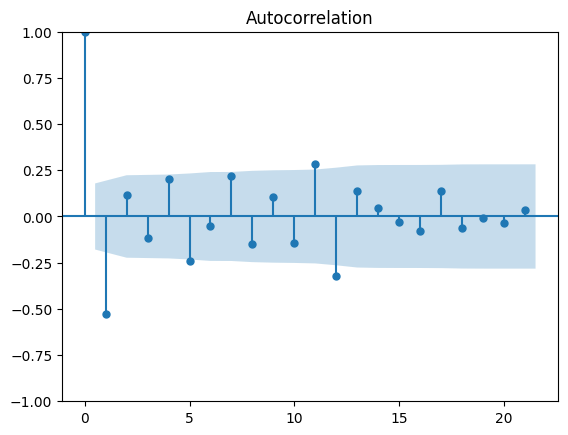

In [ ]:

# Autocorrelação ACF (ou FAC) (q)

plot_acf(owid_brasil_diff2)

# Última observação significativa (q) é 1
plt.savefig("fac_diff2.png")

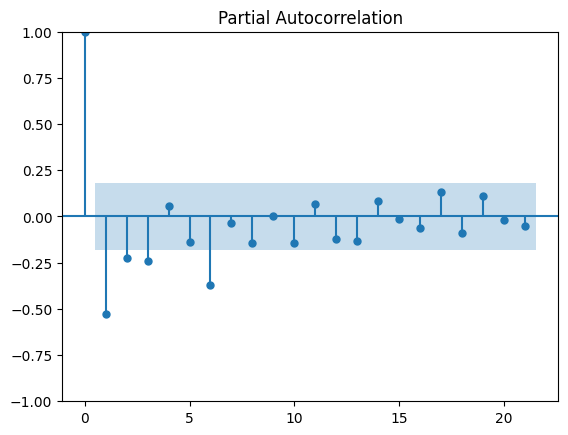

In [ ]:
# Autocorrelação parcial PACF ou FACP (p)
plot_pacf(owid_brasil_diff2)

# Última observação significativa (p) é 3
plt.savefig("facp_diff2.png")

Conforme o gráfico de autocorrelação (FAC), a última observação significativa é 1. Dessa forma, o parâmetro "q" do modelo ARIMA é 1. Já em relação a Autocorrelação Parcial (FACP), a última observação significativa também é 0. Portanto, o parâmetro "p" é 3. Além disso, houveram três diferenciações e, dessa forma, o parâmetro d é 2. Sendo assim, o modelo que será realizado é ARIMA(3,2,1).

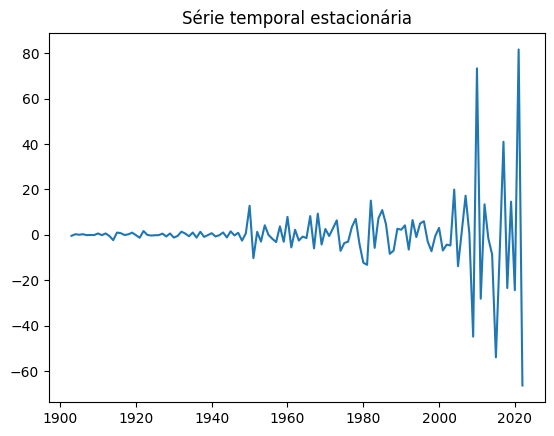

In [ ]:
# Série temporal estacionária (média 0)
plt.title('Série temporal estacionária')
plt.plot(owid_brasil_diff2)
plt.savefig("estacionariedade_diff2.png")

In [ ]:
# Load/split your data
X = owid_brasil.values
size = int(len(X) * 0.66)
train = owid_brasil['co2'].iloc[:size]
test = owid_brasil['co2'].iloc[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
# Walk forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(3,2,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs=test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

predicted=190.069631, expected=171.324000
predicted=166.578839, expected=171.500000
predicted=180.049227, expected=165.900000
predicted=167.139470, expected=167.567000
predicted=161.577799, expected=180.111000
predicted=189.510283, expected=197.238000
predicted=209.986316, expected=205.968000
predicted=212.208600, expected=207.695000
predicted=208.483789, expected=212.071000
predicted=216.163383, expected=218.658000
predicted=225.369669, expected=229.394000
predicted=237.957577, expected=233.601000
predicted=238.521225, expected=244.306000
predicted=251.528603, expected=254.002000
predicted=262.623551, expected=268.678000
predicted=278.872652, expected=289.311000
predicted=304.392577, expected=306.949000
predicted=320.602051, expected=317.359000
predicted=325.735206, expected=327.256000
predicted=336.075656, expected=340.183000
predicted=353.128194, expected=346.166000
predicted=354.214426, expected=347.765000
predicted=352.045896, expected=344.645000
predicted=346.190910, expected=361

In [ ]:

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -458.297
Date:                Tue, 20 Feb 2024   AIC                            926.595
Time:                        17:22:12   BIC                            940.490
Sample:                             0   HQIC                           932.237
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1396      0.044      3.149      0.002       0.053       0.226
ar.L2          0.1936      0.079      2.453      0.014       0.039       0.348
ar.L3         -0.0786      0.071     -1.103      0.2

# Previsão do Modelo Original ARIMA(3,2,1)

In [ ]:
# evaluate forecasts
mape = mean_absolute_percentage_error(test, predictions)
print('Test MAPE: %.3f' % mape)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test MAPE: 0.041
Test RMSE: 21.929


In [ ]:
predictions = pd.DataFrame(predictions, index=test.index)

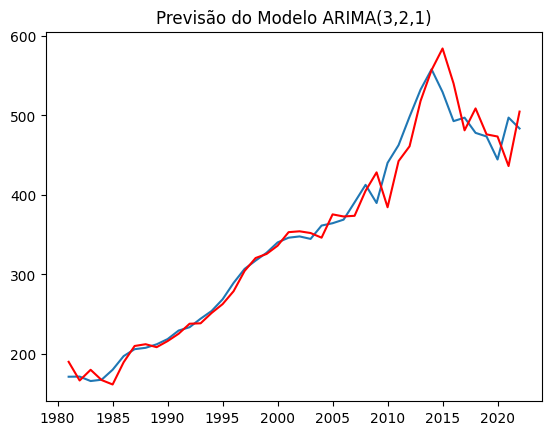

In [ ]:
# plot forecasts against actual outcomes
plt.title('Previsão do Modelo ARIMA(3,2,1)')
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
# Coeficiente de Determinação R²
print('O R² é: %.3f' % r2_score(test,predictions))

# MAPE
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, predictions))

O R² é: 0.966
Test MAPE: 0.041


# Diagnóstico do Modelo ARIMA (3,2,1)

In [ ]:
# Análise dos resíduos
residuals = pd.DataFrame(model_fit.resid)
residuals.describe()

,0
count,121.000000
mean,1.126842
std,11.181938
min,-44.535922
25%,-0.579005
50%,0.310405
75%,3.831184
max,52.734899


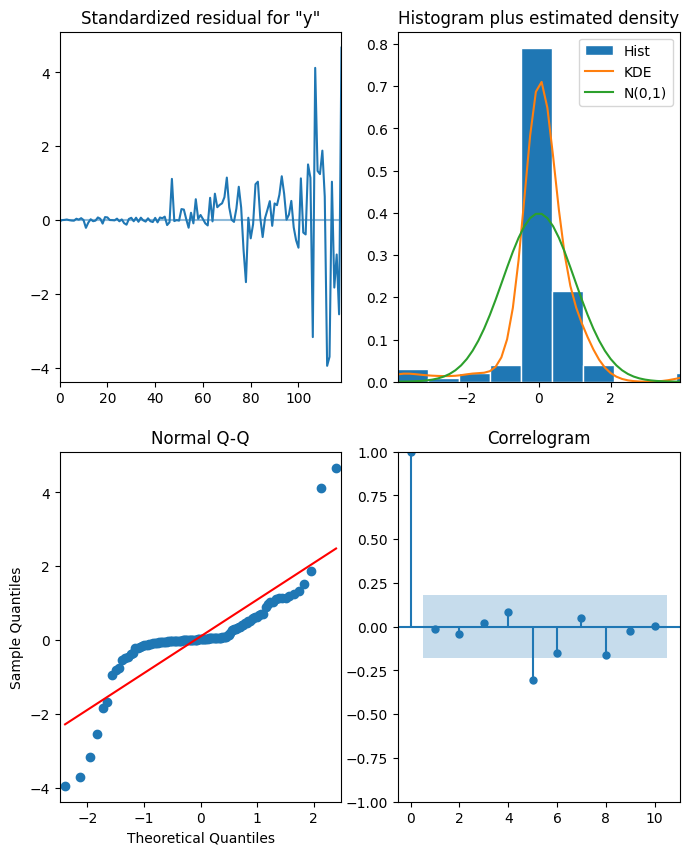

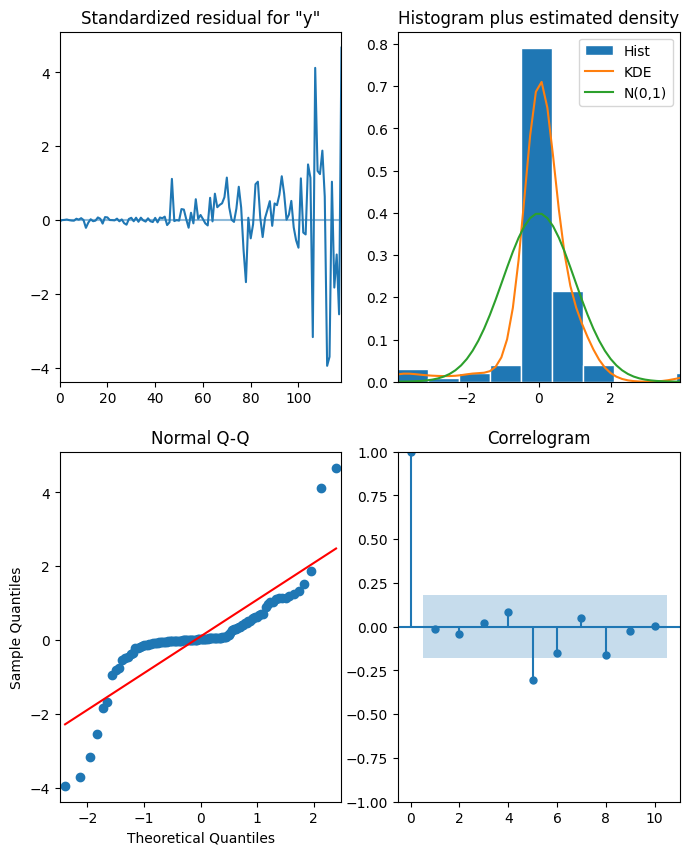

In [ ]:
# Diagnóstico do modelo

model_fit.plot_diagnostics(figsize=(8,10))

# Comparação dos parâmetros p, d e q em relação ao ARIMA automático (auto_arima)

In [ ]:
# Arima automático
arima_automatico = auto_arima(owid_brasil['co2'], trace = True, suppress_warning = True)
arima_automatico.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=999.270, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=953.903, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=936.528, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=937.872, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=938.072, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.550 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -466.264
Date:                Tue, 20 Feb 2024   AIC                            936.528
Time:                        17:22:22   BIC                            942.103
Sample:                    01-01-1901   HQIC                           938.792
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9407      0.022    -42.762      0.000      -0.984      -0.898
sigma2       136.3478     10.136     13.452      0.000     116.482     156.214
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               261.78
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):             906.05   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Análise dos resíduos
O **teste Ljung-Box (L1) (Q)** testa se os resíduos são independentes, ou seja, são **ruído branco**. A probabilidade Q Prob(Q) de 0,73 está acima de 0,05 e, portanto, não é possível rejeitar a hipótese nula de que os erros são ruído branco.

A **heterocedasticidade** testa se os resíduos possuem a mesma variância. A Prob(H) é de 0,00 e, portanto, é menor que 0,05. Dessa forma, rejeita-se a hipótese nula de que os resíduos são homocedásticos. Ou seja, os resíduos apresentam variância.

O **teste Jarque-Bera (JB)** testa a normalidade dos erros. Como Prob(JB) de 0.00 é menor que o p-value de 0.05, a hipótese nula é rejeitada. Dessa forma, considera-se a não-normalidade dos resíduos.

Fonte: [How to Interpret ARIMA Results](https://analyzingalpha.com/interpret-arima-results#3_Review_Assumptions)

# Transformação de Box Cox

Como o modelo é heterocedástico e não apresenta normalidade dos erros, existem estratégias para que essa situação seja contornada. Em relação a heterocedasticidade, é possível transformar a base de dados a partir da transformação de Box Cox (MORETTIN, Pedro A, 2018)


In [ ]:
# Aplicando a transformação de Box Cox
owid_brasil_boxcox = boxcox(owid_brasil['co2'])
owid_brasil['boxcox'] = owid_brasil_boxcox[0]
owid_boxcox_lam = owid_brasil_boxcox[1]

In [ ]:
owid_brasil['boxcox']
owid_boxcox_lam

0.03488312059469478

In [ ]:
# Load/split boxcox data
X = owid_brasil['boxcox'].values
train_boxcox = owid_brasil['boxcox'].iloc[:size]
test_boxcox = owid_brasil['boxcox'].iloc[size:len(X)]
history_boxcox = [x for x in train_boxcox]
predictions_boxcox = list()

In [ ]:
# Testando a estacionariedade
# Aplicação da função

adfuller_test(owid_brasil['boxcox'], autolag_escolhido)

Série temporal não-estacionária com p-value igual a: 0.8669501844836285


(-0.6176223024890755,
 0.8669501844836285,
 0,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 -112.35530826421291)

In [ ]:
# Testando a estacionariedade (diferenciando novamente)

owid_boxcox_diff1 = owid_brasil['boxcox'].diff().dropna()
adfuller_test(owid_boxcox_diff1, autolag_escolhido)

Série temporal estacionária com p-value igual a: 1.1415772169042062e-17


(-10.088033429999467,
 1.1415772169042062e-17,
 0,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 -115.58930700730758)

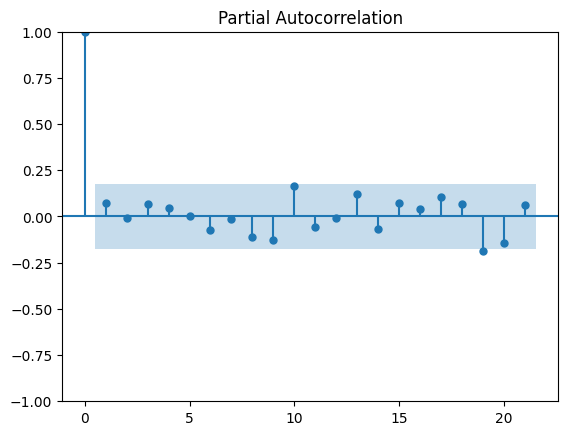

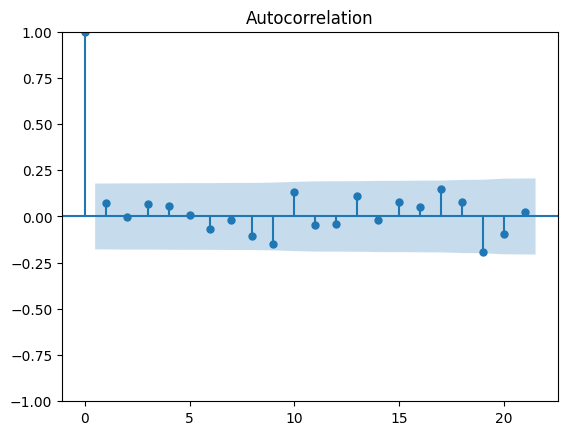

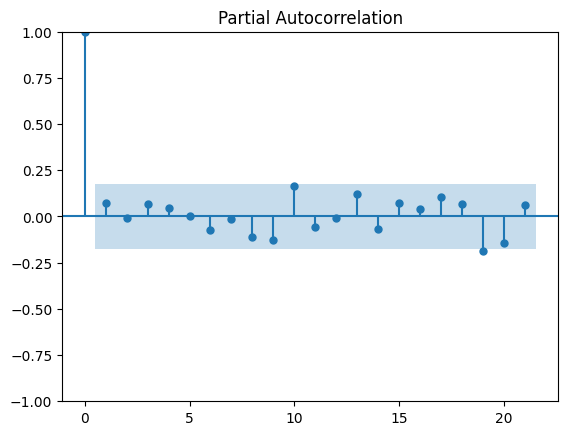

In [ ]:
# FAC
plot_acf(owid_boxcox_diff1)

## última observação significativa: 0

# PACF
plot_pacf(owid_boxcox_diff1)
## última observação siginificativa: 0

In [ ]:
# Walk forward validation
for t in range(len(test_boxcox)):
    model_boxcox = ARIMA(history_boxcox, order=(0, 1, 0))
    model_fit_boxcox = model_boxcox.fit()
    output_boxcox = model_fit_boxcox.forecast()
    yhat_boxcox = output_boxcox[0]
    predictions_boxcox.append(yhat_boxcox)
    obs_boxcox = test_boxcox.iloc[t]
    history_boxcox.append(obs_boxcox)
    print('predicted=%f, expected=%f' % (yhat_boxcox, obs_boxcox))

predicted=5.733590, expected=5.633875
predicted=5.633875, expected=5.635103
predicted=5.635103, expected=5.595402
predicted=5.595402, expected=5.607354
predicted=5.607354, expected=5.693773
predicted=5.693773, expected=5.802826
predicted=5.802826, expected=5.854942
predicted=5.854942, expected=5.864998
predicted=5.864998, expected=5.890124
predicted=5.890124, expected=5.927016
predicted=5.927016, expected=5.984906
predicted=5.984906, expected=6.006881
predicted=6.006881, expected=6.061119
predicted=6.061119, expected=6.108301
predicted=6.108301, expected=6.176508
predicted=6.176508, expected=6.266554
predicted=6.266554, expected=6.338744
predicted=6.338744, expected=6.379495
predicted=6.379495, expected=6.417058
predicted=6.417058, expected=6.464503
predicted=6.464503, expected=6.485876
predicted=6.485876, expected=6.491527
predicted=6.491527, expected=6.480476
predicted=6.480476, expected=6.538842
predicted=6.538842, expected=6.548782
predicted=6.548782, expected=6.563864
predicted=6.

In [ ]:
# ARIMA(p,d,q)
print(model_fit_boxcox.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  56.206
Date:                Tue, 20 Feb 2024   AIC                           -110.412
Time:                        17:22:24   BIC                           -107.624
Sample:                             0   HQIC                          -109.280
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0229      0.001     25.146      0.000       0.021       0.025
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):              2288.54
Prob(Q):                              0.38   Pr

# Previsão do modelo Box Cox ARIMA(0,1,0)

In [ ]:
predictions_boxcox = pd.DataFrame(predictions_boxcox, index=test_boxcox.index)

In [ ]:
# evaluate forecasts
mape_boxcox = mean_absolute_percentage_error(test_boxcox, predictions_boxcox)
print('Test MAPE: %.3f' % mape_boxcox)

rmse_boxcox = sqrt(mean_squared_error(test_boxcox, predictions_boxcox))
print('Test RMSE: %.3f' % rmse_boxcox)

Test MAPE: 0.008
Test RMSE: 0.064


In [ ]:
# Comparando as previsões com os dados de teste
predictions_original = inv_boxcox(predictions_boxcox, owid_boxcox_lam)  # Função inversa da transformação de Box Cox

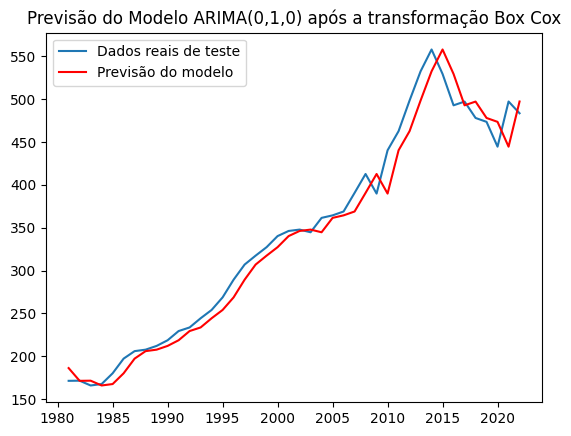

In [ ]:
# plot forecasts against actual outcomes
plt.title('Previsão do Modelo ARIMA(0,1,0) após a transformação Box Cox')
plt.plot(test, label='Dados reais de teste')
plt.plot(predictions_original, color='red', label='Previsão do modelo')
plt.legend()
plt.show()

In [ ]:
# Coeficiente de Determinação R²
print('O R² é: %.3f' % r2_score(test,predictions_original))

# MAPE
print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, predictions_original))

O R² é: 0.972
Test MAPE: 0.043


In [ ]:
arima_automatico_boxcox = auto_arima(owid_brasil['boxcox'], trace = True, suppress_warning = True)
arima_automatico_boxcox.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-117.874, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-124.848, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-123.542, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-123.558, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-112.300, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-121.531, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.508 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  64.424
Date:                Tue, 20 Feb 2024   AIC                           -124.848
Time:                        17:22:24   BIC                           -119.256
Sample:                    01-01-1901   HQIC                          -122.577
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0508      0.015      3.344      0.001       0.021       0.081
sigma2         0.0202      0.001     22.385      0.000       0.018       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):              2330.94
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             2.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Análise dos resíduos
O **teste Ljung-Box (L1) (Q)** testa se os resíduos são independentes, ou seja, são **ruído branco**. A probabilidade Q Prob(Q) de 0,49 está acima de 0,05 e, portanto, não é possível rejeitar a hipótese nula de que os erros são ruído branco.

A **heterocedasticidade** testa se os resíduos possuem a mesma variância. A Prob(H) é de 0,00 e, portanto, é menor que 0,05. Dessa forma, rejeita-se a hipótese nula de que os resíduos são homocedásticos. Ou seja, os resíduos apresentam variância.

O **teste Jarque-Bera (JB)** testa a normalidade dos erros. Como Prob(JB) de 0.00 é menor que o p-value de 0.05, a hipótese nula não é rejeitada. Dessa forma, considera-se a não-normalidade dos resíduos.

Fonte: [How to Interpret ARIMA Results](https://analyzingalpha.com/interpret-arima-results#3_Review_Assumptions)

In [ ]:
# Análise dos resíduos
residuals_boxcox = pd.DataFrame(model_fit_boxcox.resid)
residuals_boxcox.describe()

,0
count,121.000000
mean,0.057295
std,0.156081
min,-0.407051
25%,-0.001077
50%,0.057891
75%,0.105961
max,1.070560


# Diagnóstico do modelo Box Cox ARIMA (0,1,0)

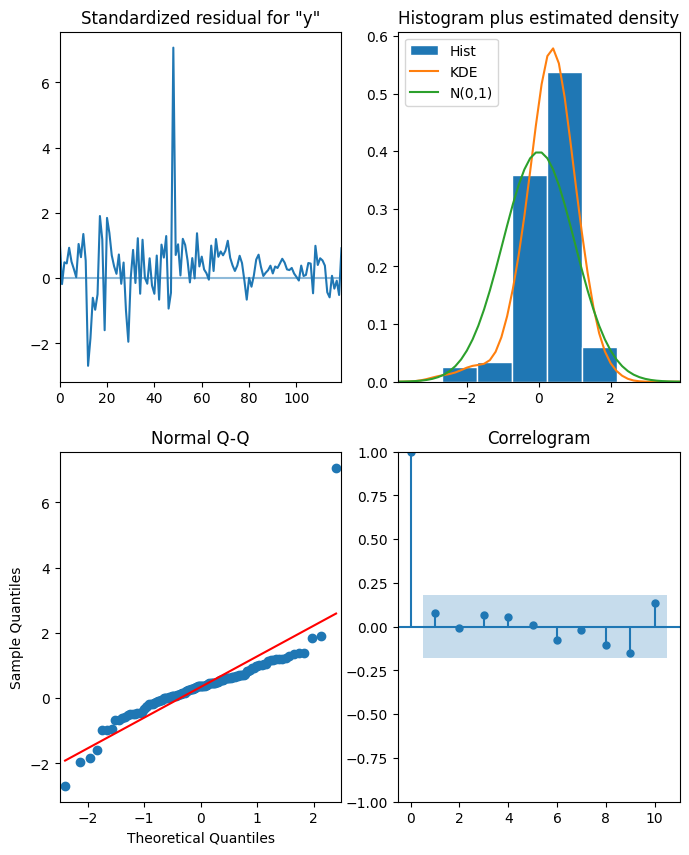

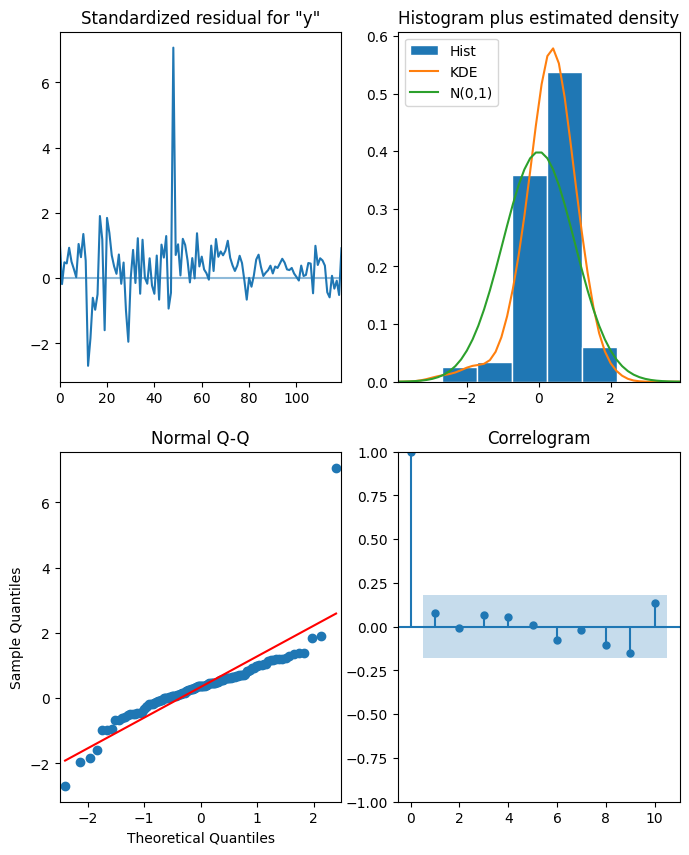

In [ ]:
# Diagnóstico do modelo

model_fit_boxcox.plot_diagnostics(figsize=(8,10))

In [ ]:
diag_heterocedasticidade = model_fit_boxcox.test_heteroskedasticity(method = 'breakvar')

print('p-value:', diag_heterocedasticidade[0][1])

p-value: 1.1150107707152504e-07


The null hypothesis is of no heteroskedasticity. The p-value rejects the null hypothesis, therefore there is heteroskedascity.